In [316]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import shap
from IPython.display import display

from xgboost import plot_importance
from xgboost import XGBRegressor, plot_importance, plot_tree, plotting

import dtreeviz
import graphviz


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# #for hyperparameter tuning
# import hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [317]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [318]:
df_bb= load_dataset('cleaned_files/basketball_clean_supervised.csv')
df_fb= load_dataset('cleaned_files/football_clean_supervised.csv')

In [319]:
#save athlete names for later indexing
athletes_fb = df_fb['NAME']
athletes_bb = df_bb['NAME']
# athlete_names

df_bb = df_bb.drop(columns=['Unnamed: 0', 'NAME','SPORT','STARCOLL','EXP_YEARS','institution_name_short'])
df_fb= df_fb.drop(columns=['Unnamed: 0', 'NAME','SPORT', 'STARCOLL','EXP_YEARS','institution_name_short'])


In [320]:
# df_bb.head()


In [321]:
#Descriptive statistics of the target variable


def format_dollars(x):
    return f'{x:.2f}'
   
# Set the formatting function for float values
pd.options.display.float_format = format_dollars

# Assuming df_bb is your DataFrame
summary = df_bb['NILVAL_LONG_USD'].describe()
print(summary)

count       137.00
mean     266379.56
std      539449.37
min       60000.00
25%       90000.00
50%      145000.00
75%      288000.00
max     6100000.00
Name: NILVAL_LONG_USD, dtype: float64


In [322]:
#Mode value
df_bb.NILVAL_LONG_USD.mode()

0   108000.00
dtype: float64

Mean ($266,379.56) is greater than  median ($145,000.00), and the 75th percentile ($288,000.00) is substantially greater than the 25th percentile ($90,000.00). This indicates that the data is positively skewed, with a longer tail on the right side of the distribution.

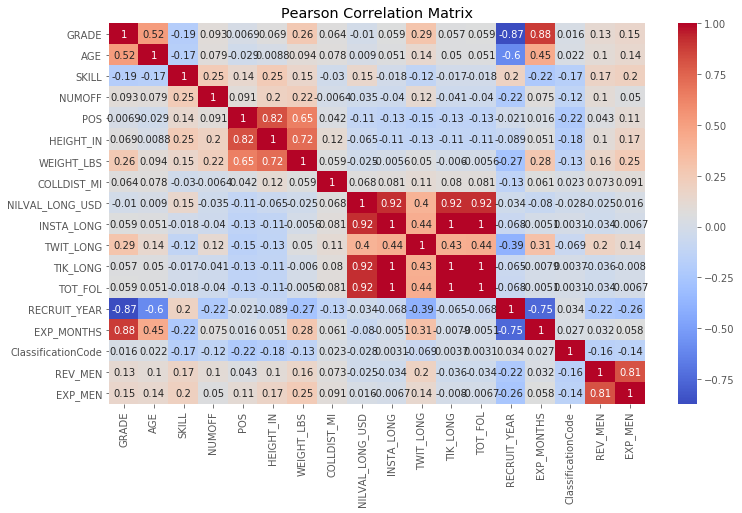

In [323]:
#Pearson Correlation matrix
plt.figure(figsize=(12,7))
plt.title('Pearson Correlation Matrix')
sns.heatmap(df_bb.corr(),annot=True, cmap = 'coolwarm')

Looking like there is some high correlation with Recruit year and other features (GRADE, EXP MONTHS) and TOT_FOL with othe social media counts

In [324]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'TOT_FOL', 'RECRUIT_YEAR', 'EXP_MONTHS', 'ClassificationCode',
       'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [325]:
df_bb=df_bb.copy()
df_bb=df_bb.drop(columns=['RECRUIT_YEAR','TOT_FOL'])
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

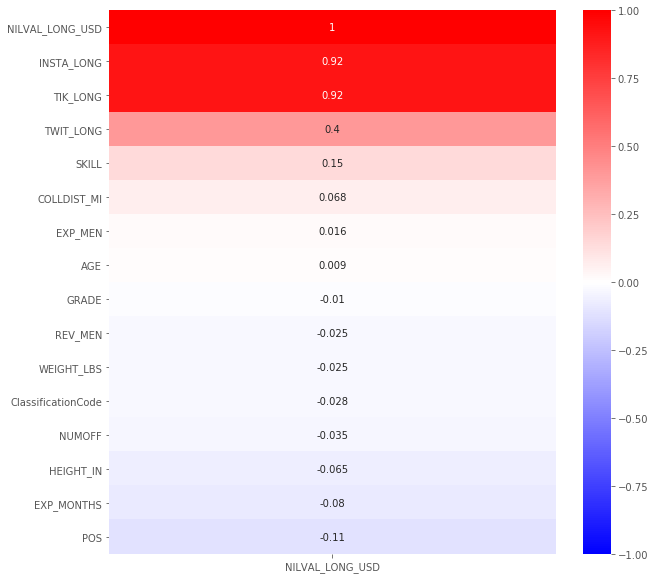

In [326]:
#Correlation heatmap
#https://stackoverflow.com/questions/72213733/how-to-plot-seaborn-heatmap-for-target-vs-independent-features
#+1= highly and positively correlated and -1 = highly negatively correlated.
def corr_plot(df):
    corr_matrix = df.corr()
    data=pd.DataFrame(corr_matrix['NILVAL_LONG_USD'].sort_values(ascending=False))  #plotting all but could do top (>.50)
    plt.figure(figsize = (10,10))
    return  sns.heatmap(data, annot=True, vmin=-1, vmax=1, cmap='bwr')
    # ax.tick_params(labelrotation=0)

corr_plot(df_bb)

In [327]:
#outliers check
def outl(x):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.boxplot(df_bb[x])
    plt.subplot(122)
    sns.distplot(df_bb[x])
    plt.tight_layout()
    plt.show()

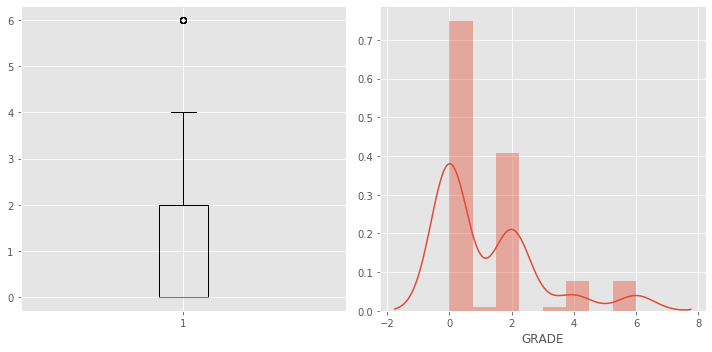

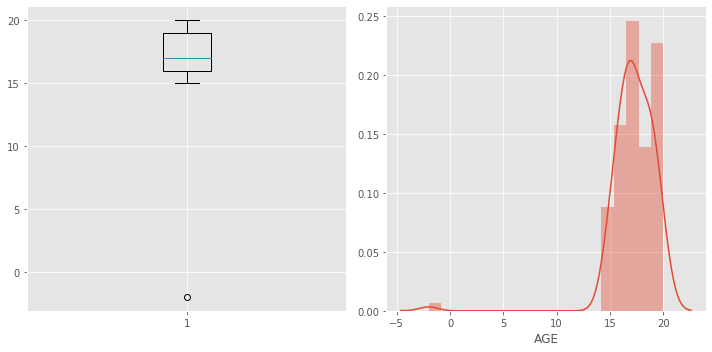

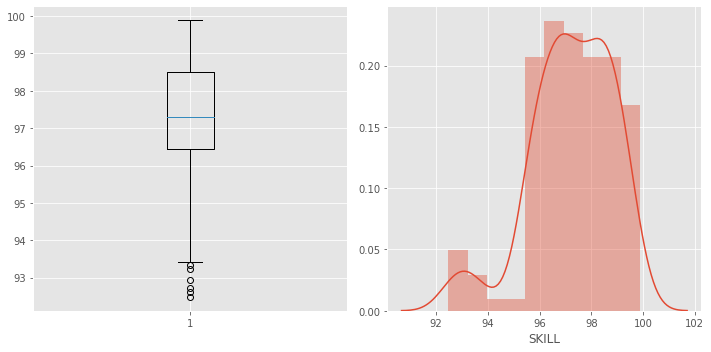

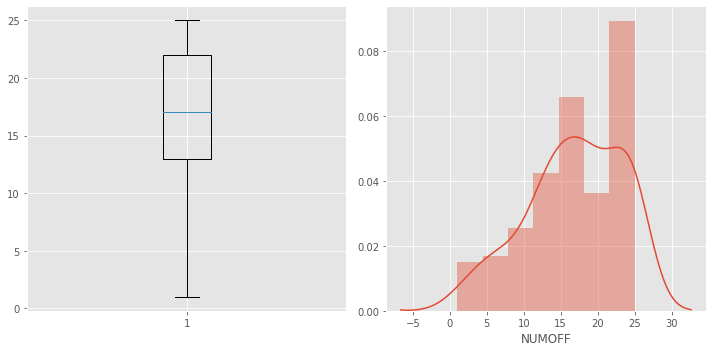

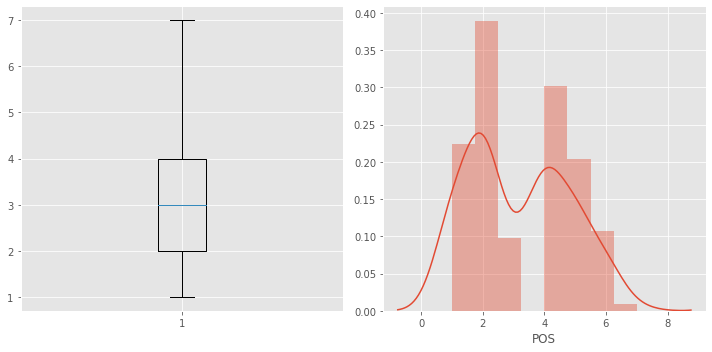

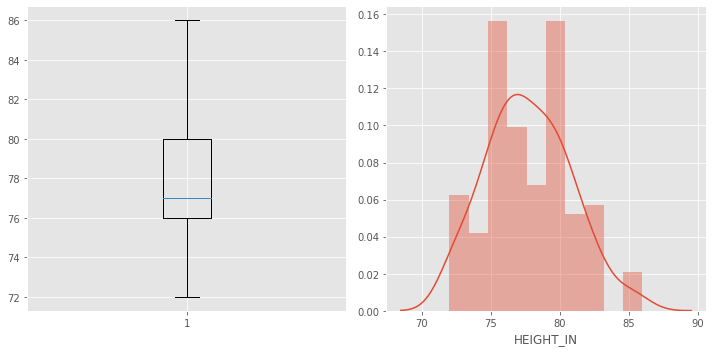

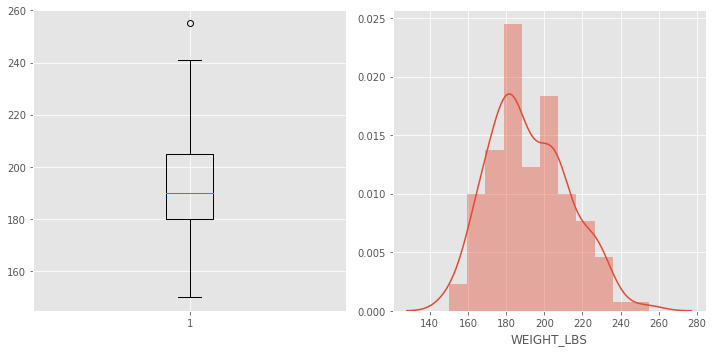

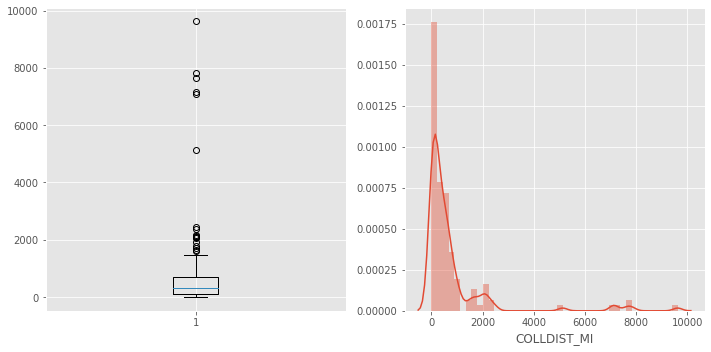

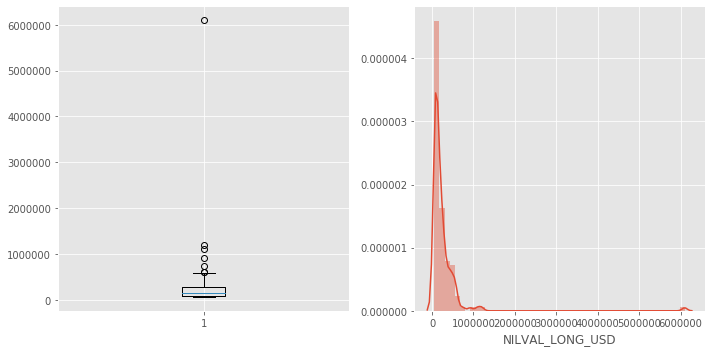

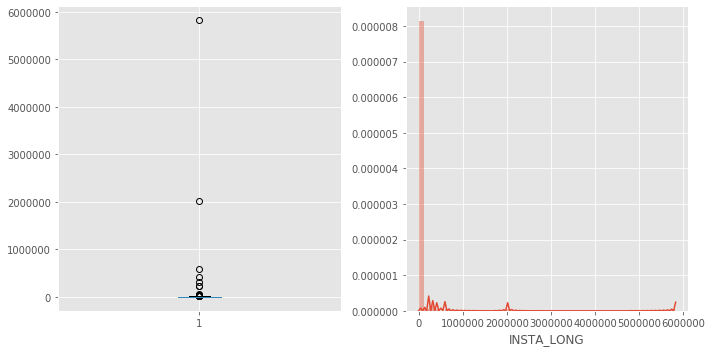

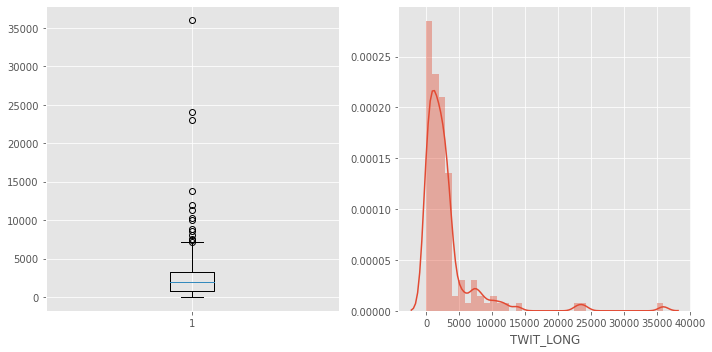

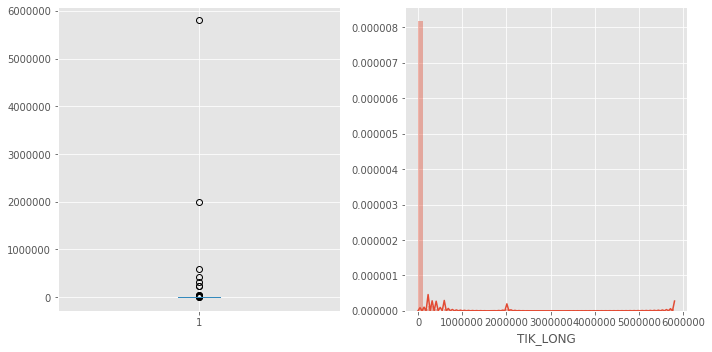

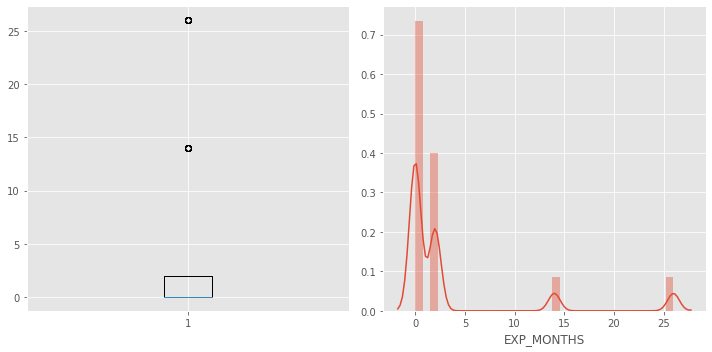

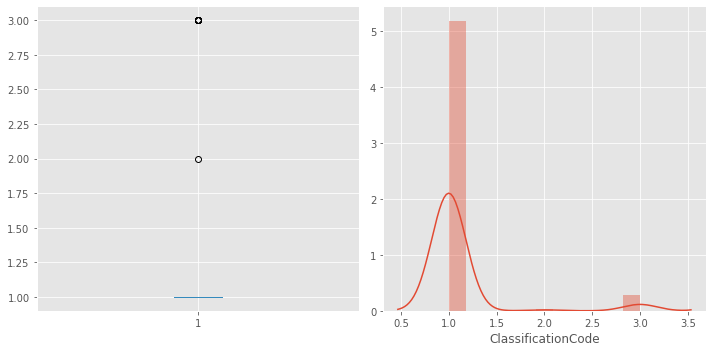

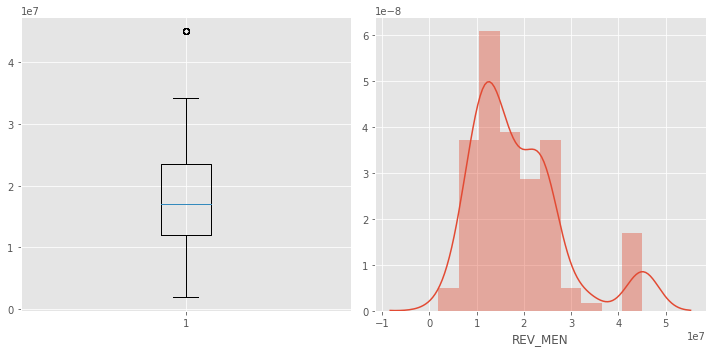

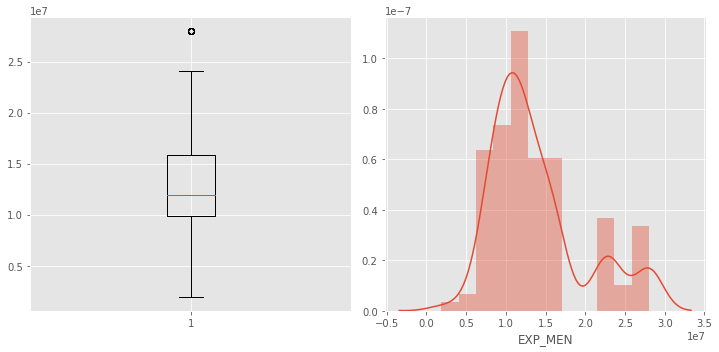

In [328]:
for col in df_bb.columns:
    outl(col)

Do outlier treatment for TIK_LONG, TWIt_LONG, INSTA_LONG, COLL_DIST

In [329]:
df_bb.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

In [330]:
columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# Create a dictionary to store the descriptions
descriptions = {}

for col in columns:
    descriptions[col] = df_bb[col].describe()

# Display the descriptions for each column
for col, description in descriptions.items():
    print(f"Summary statistics for {col}:")
    print(description)
    print()

Summary statistics for COLLDIST_MI:
count    137.00
mean     799.57
std     1553.41
min        0.00
25%       95.00
50%      315.00
75%      682.00
max     9625.00
Name: COLLDIST_MI, dtype: float64

Summary statistics for INSTA_LONG:
count       137.00
mean      75603.12
std      528131.46
min           0.00
25%        1100.00
50%        2424.00
75%        8500.00
max     5824000.00
Name: INSTA_LONG, dtype: float64

Summary statistics for TWIT_LONG:
count     137.00
mean     3063.25
std      4588.23
min         0.00
25%       762.00
50%      1900.00
75%      3300.00
max     36000.00
Name: TWIT_LONG, dtype: float64

Summary statistics for TIK_LONG:
count       137.00
mean      72539.88
std      526149.65
min           0.00
25%           0.00
50%           0.00
75%        2800.00
max     5800000.00
Name: TIK_LONG, dtype: float64



In [331]:
#using iqr method, considering both including and excluding the lower and upper limits into two separate dataframes, 
# then merging both the dataframes into one.
#goal is to filter the data to remove or cap extreme values, and then merge the resulting data back together
q1 = df_bb['INSTA_LONG'].quantile(0.25)
q2 = df_bb['INSTA_LONG'].quantile(0.50)
q3 = df_bb['INSTA_LONG'].quantile(0.75)
IQR = q3-q1

lower_limit = q1-1.5*IQR
upper_limit = q3+1.5*IQR

data_inc = df_bb.loc[(df_fb['INSTA_LONG']>=lower_limit) & (df_bb['INSTA_LONG']<=upper_limit)]
data_esc = df_bb.loc[(df_fb['INSTA_LONG']>lower_limit) & (df_bb['INSTA_LONG']<upper_limit)]
df_bb2 = pd.concat([data_inc,data_esc])
df_bb2.head()

,GRADE,AGE,SKILL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,COLLDIST_MI,NILVAL_LONG_USD,INSTA_LONG,TWIT_LONG,TIK_LONG,EXP_MONTHS,ClassificationCode,REV_MEN,EXP_MEN
0,2.00,18.00,99.39,17.00,1.00,75.00,190.00,1921.00,594000.00,2800.00,2800.00,0.00,2.00,1.00,7241439.00,9496433.00
2,0.00,17.00,95.87,18.00,2.00,77.00,205.00,2445.00,80000.00,1900.00,1900.00,0.00,0.00,1.00,7241439.00,9496433.00
3,0.00,17.00,95.76,22.00,2.00,77.00,170.00,15.00,93000.00,0.00,0.00,0.00,0.00,1.00,7241439.00,9496433.00
4,0.00,15.00,97.22,4.00,4.00,77.00,170.00,11.00,109000.00,249.00,249.00,0.00,0.00,1.00,7241439.00,9496433.00
5,2.00,19.00,99.34,25.00,4.00,79.00,180.00,518.00,560000.00,13200.00,2200.00,11000.00,2.00,1.00,22667255.00,22667255.00


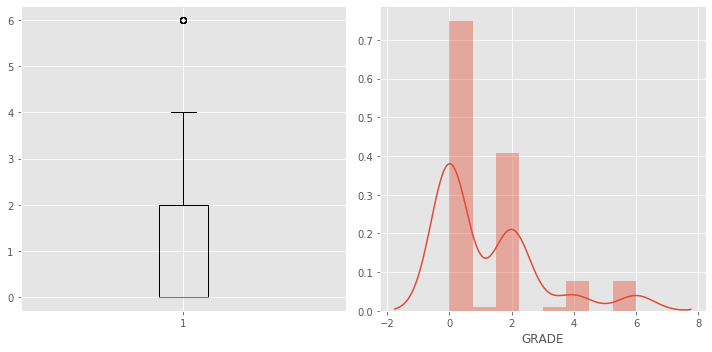

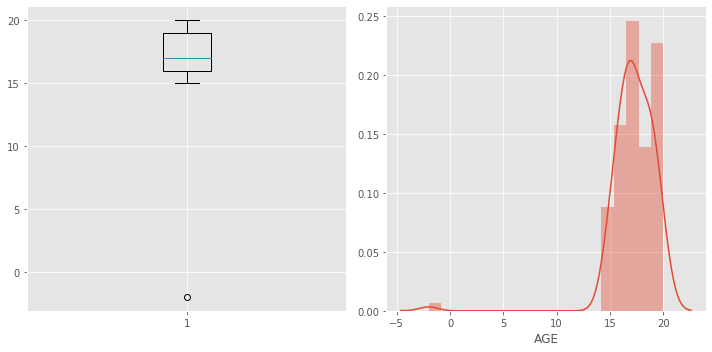

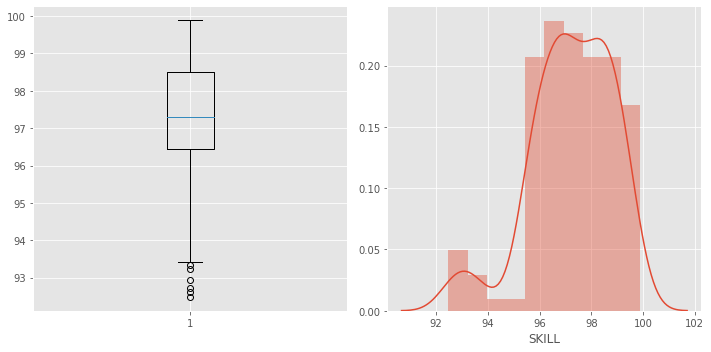

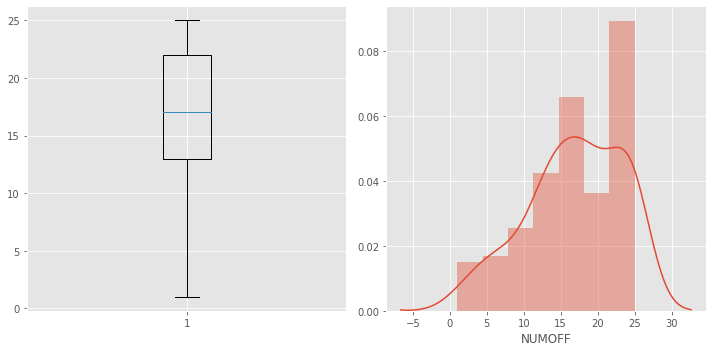

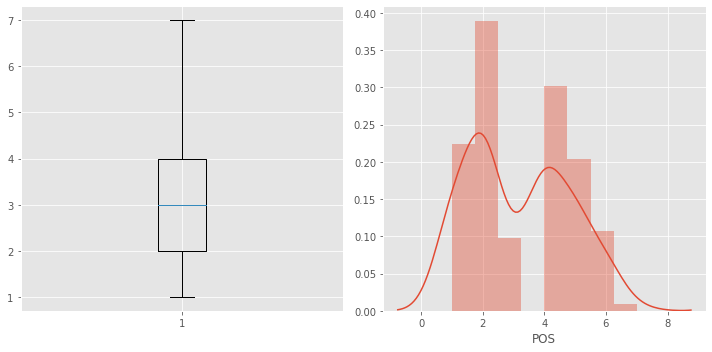

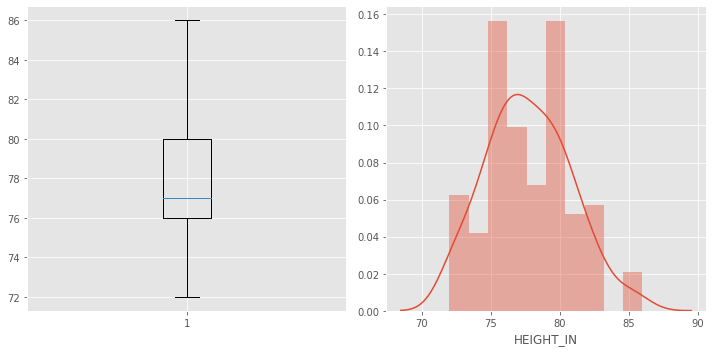

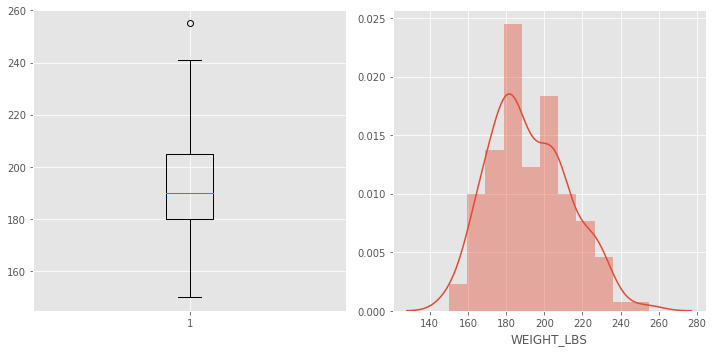

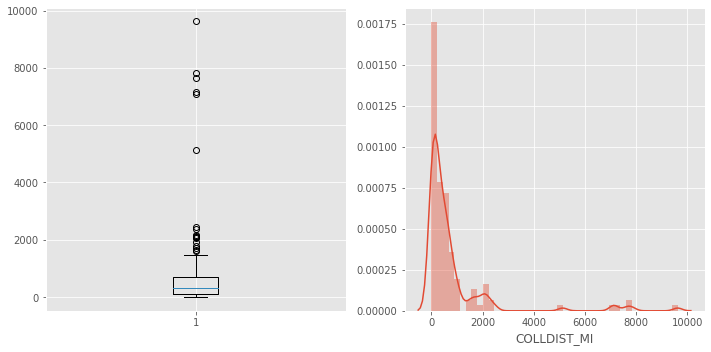

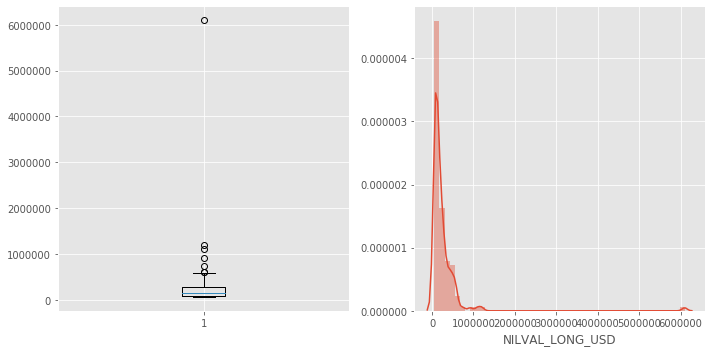

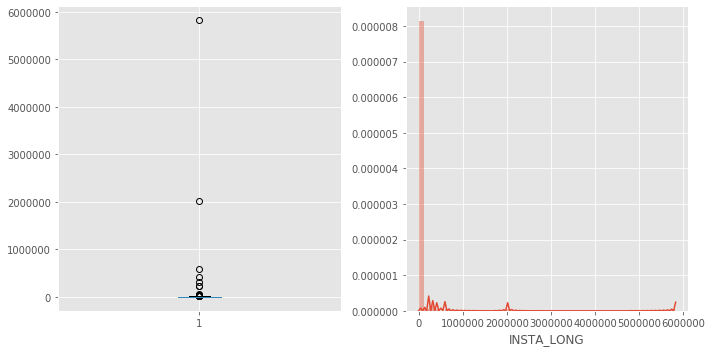

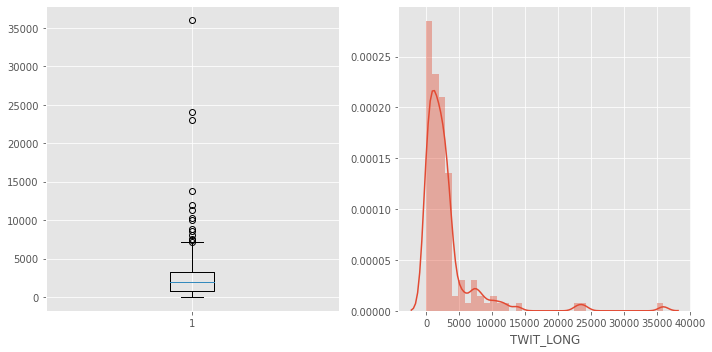

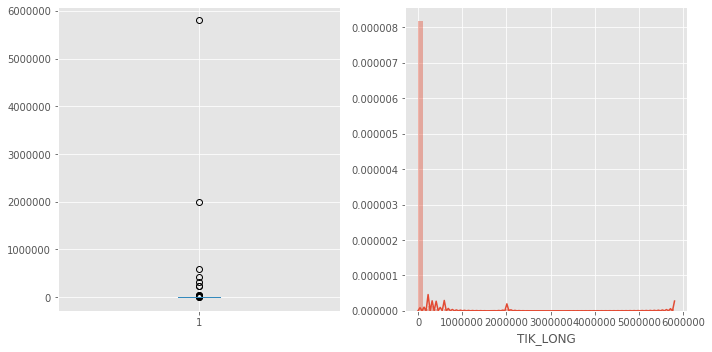

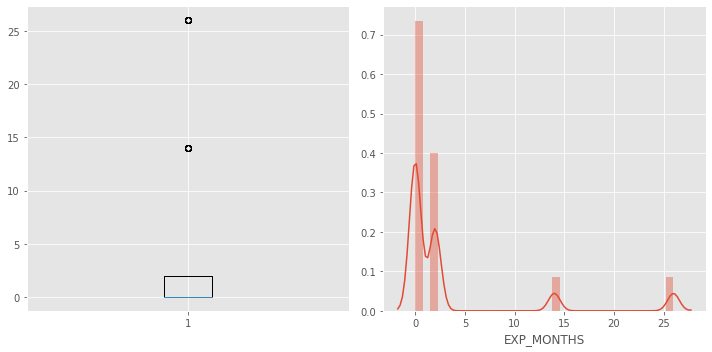

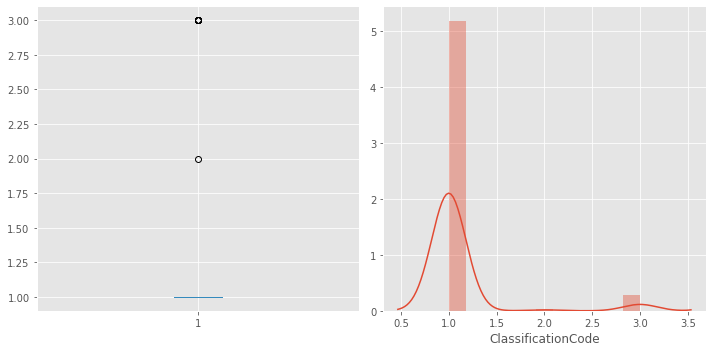

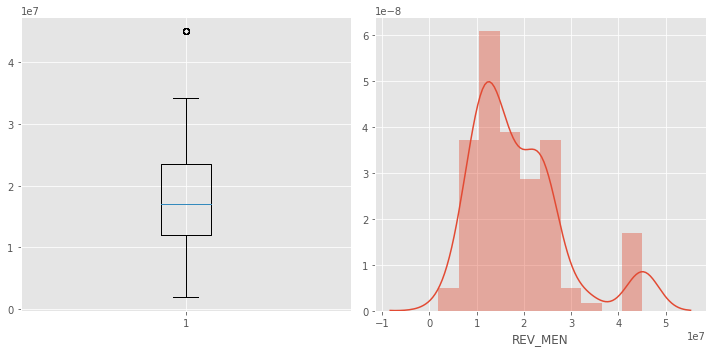

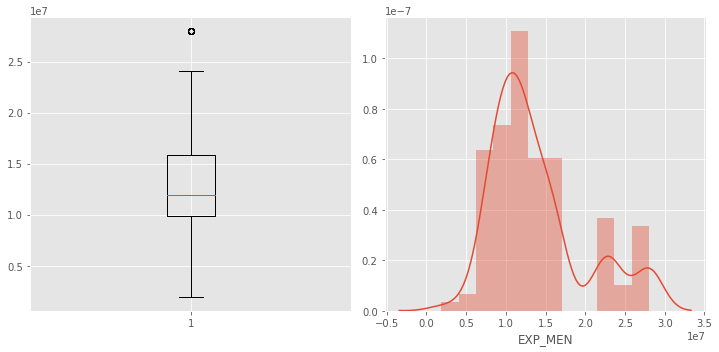

In [332]:
for col in df_bb2.columns:
    outl(col)

In [333]:
# columns = ['COLLDIST_MI',  'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',]

# # Create a dictionary to store the descriptions
# descriptions = {}

# for col in columns:
#     descriptions[col] = df_bb2[col].describe()

# # Display the descriptions for each column
# for col, description in descriptions.items():
#     print(f"Summary statistics for {col}:")
#     print(description)
#     print()

In [334]:
# df_bb2['INSTA_LONG'].describe
df_bb2.shape

(244, 16)

**Linear Regression**

In [335]:
train_bb, test_bb = train_test_split(df_bb2, test_size=0.20, shuffle=True, random_state=42)
print('Shape for train_bb is {0}, df_test is {1}'.format(train_bb.shape,test_bb.shape))

Shape for train_bb is (195, 16), df_test is (49, 16)


In [336]:
#Feature scaling using standard scaler

# def fscale(train,test):
    # scaler = MinMaxScaler()
    # scaler = StandardScaler()
    # train = scaler.fit_transform(train)
    # test = scaler.transform(test)
    
    # return train, test

In [337]:
# #calling  above function
# train_bb_sc,test_bb_sc = fscale(train_bb,test_bb)

In [338]:
# train_bb_sc = pd.DataFrame(train_bb_sc,columns=df_fb2.columns)
# train_bb_sc.head()

In [339]:
#Check test
# test_bb_sc = pd.DataFrame(test_bb_sc,columns=df_fb2.columns)
# test_bb_sc.head()

In [340]:
# y_trainbb_sc = train_bb_sc['NILVAL_LONG_USD']
# X_trainbb_sc = train_bb_sc.drop('NILVAL_LONG_USD',axis=1)
# y_testbb_sc = test_bb_sc['NILVAL_LONG_USD']
# X_testbb_sc = test_bb_sc.drop('NILVAL_LONG_USD',axis=1)

In [341]:
#check
# y_testbb_sc

In [342]:
# train_bb
# test_bb

y_trainbb = train_bb['NILVAL_LONG_USD']
X_trainbb = train_bb.drop('NILVAL_LONG_USD',axis=1)
y_testbb= test_bb['NILVAL_LONG_USD']
X_testbb = test_bb.drop('NILVAL_LONG_USD',axis=1)

# y_testbb

**Linear Regression - All Features**

In [343]:
#Get metrics
'''1 - r2 is the reduction in unexplained variance due to the model.
(n - 1) is the total degrees of freedom in the data.
(n - p - 1) is the degrees of freedom adjusted for the number of predictors used in the model.'''

#function for adjusted r2_score
def adjusted_r2_score(data,y_true,y_pred):
    r2 = r2_score(y_true,y_pred)
    n = data.shape[0]
    p = data.shape[1]
    adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adj_r2

#function for rmse
def rmse(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    return rmse

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [344]:
lr = LinearRegression()

lr.fit(X_trainbb, y_trainbb)
y_pred_trainbb_lr = lr.predict(X_trainbb)
y_pred_testbb_lr = lr.predict(X_testbb)

print('R2 score of train data is ',r2_score(y_trainbb,y_pred_trainbb_lr))
print('rmse score of train data is ',rmse(y_trainbb,y_pred_trainbb_lr))
print('mae score of train data is ',mae(y_trainbb,y_pred_trainbb_lr))
print()
print('R2 score of test data is ',r2_score(y_testbb,y_pred_testbb_lr))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_testbb,y_testbb,y_pred_testbb_lr))
print('rmse score of test data is ',rmse(y_testbb,y_pred_testbb_lr))
print('mae score of test data is ',mae(y_testbb,y_pred_testbb_lr))

R2 score of train data is  0.24306833477528078
rmse score of train data is  159328.63586104635
mae score of train data is  96056.80112831375

R2 score of test data is  0.521264191426877
Adj. R2 score of test data is  0.3036570057118211
rmse score of test data is  116300.95965740323
mae score of test data is  93021.816501609


**LInear Regression Feature selection using RFE ( Recursive Feature Elimination)**

In [345]:
#features/ nof(number of features)
       

features = X_trainbb.columns.tolist()
nof_list = np.arange(1,len(features)+1)   
high_score=0

#Variable to store the optimum features-
nof=0    
score_list =[]

for n in range(len(nof_list)):
    
    lr = LinearRegression()
    rfe = RFE(lr,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
    X_test_rfe = rfe.transform(X_testbb)
    lr.fit(X_train_rfe,y_trainbb)
    score = lr.score(X_test_rfe,y_testbb)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 15
Score with 15 features: 0.521264


In [346]:
#RFE with 15 features
lr = LinearRegression()
rfe = RFE(lr,15)
X_trainbb_rfe = rfe.fit_transform(X_trainbb,y_trainbb)
X_testbb_rfe = rfe.transform(X_testbb)

#Fitting the data to model
lr.fit(X_trainbb_rfe,y_trainbb)              
temp = pd.Series(rfe.support_,index = features)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG', 'EXP_MONTHS',
       'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')


In [347]:
#predictions
y_pred_trainbb_rfe = lr.predict(X_trainbb_rfe)
y_pred_testbb_rfe = lr.predict(X_testbb_rfe)

In [348]:
print('R2 score of train data is ',r2_score(y_trainbb,y_pred_trainbb_rfe))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainbb_rfe,y_trainbb,y_pred_trainbb_rfe))
print('rmse score of train data is ',rmse(y_trainbb, y_pred_trainbb_rfe))
print('mae score of train data is ',mae(y_trainbb, y_pred_trainbb_rfe))
print()
print('R2 score of test data is ',r2_score(y_testbb, y_pred_testbb_rfe))
print('Adj. R2 score of test data is ',adjusted_r2_score(X_test_rfe,y_testbb,y_pred_testbb_rfe))
print('rmse score of test data is ',rmse(y_testbb, y_pred_testbb_rfe))
print('mae score of test data is ',mae(y_testbb, y_pred_testbb_rfe))



R2 score of train data is  0.24306833477528078
Adj. R2 score of train data is  0.17963830696315353
rmse score of train data is  159328.63586104635
mae score of train data is  96056.80112831375

R2 score of test data is  0.521264191426877
Adj. R2 score of test data is  0.3036570057118211
rmse score of test data is  116300.95965740323
mae score of test data is  93021.816501609


In [405]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#cross validation 
# Fit RFE to your data
X_trainbb_rfe = rfe.fit_transform(X_trainbb, y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}


# Perform k-fold cross-validation and get scores
results = cross_validate(lr, X_trainbb_rfe, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = results['test_r2']
rmse_scores = np.sqrt(-results['test_neg_mean_squared_error'])
mae_scores = -results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 Score:", round (mean_r2_cv,3))
print("Mean RMSE Score:", round (mean_rmse_cv,3))
print("Mean MAE Score:", round (mean_mae_cv,3))

#return DF
meancv_scores_dict = { "Model" : 'Linear Regression RFE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)



Mean R2 Score: -0.257
Mean RMSE Score: 169552.037
Mean MAE Score: 110564.662


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression RFE,-0.26,169552.04,110564.66


In [350]:
results = pd.DataFrame(columns = ['Algorithm',
                                  'Train_R2 score',
                                  'Train_Adj_R2 score',
                                  'Train_RMSE score',
                                  'Train_MAE score',
                                  'Test_R2 score',
                                  'Test_Adj_R2 score',
                                  'Test_RMSE score',
                                  'Test_MAE score', 
                                #   'Mean CV R2 Score',
                                #   'Mean RMSE CV Score',
                                #   'Mean MAE CV Score'

]) 
results.loc[len(results)] = ['Linear Regression_RFE',
                             r2_score(y_trainbb, y_pred_trainbb_rfe),
                             adjusted_r2_score(X_train_rfe, y_trainbb, y_pred_trainbb_rfe),
                             rmse(y_trainbb, y_pred_trainbb_rfe),
                             mae(y_trainbb, y_pred_trainbb_rfe),
                             r2_score(y_testbb, y_pred_testbb_rfe),
                             adjusted_r2_score(X_test_rfe, y_testbb, y_pred_testbb_rfe),
                             rmse(y_testbb, y_pred_testbb_rfe),
                             mae(y_testbb, y_pred_testbb_rfe),
                            #  mean_r2_cv,
                            #  mean_mae_cv,
                            #  mean_rmse_cv
                             
                             
                             
                             ]
results

,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.24,0.18,159328.64,96056.80,0.52,0.30,116300.96,93021.82


**Feature Selection- Backward Elimination**
<br> Start with all features. Iteratively remove  worst performing features one by one unitl the overall model performance comes in acceptable range. p-value is performance metric.If p-value is above 0.05, then feature is removed; else keep feature

In [351]:
#https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

#Importing statsmodels
import statsmodels.api as sm
#Function for model building and fitting
def lr_sm(X_train,y_train):
    X_train_const = sm.add_constant(X_train)
    lr = sm.OLS(y_train,X_train_const).fit()
    return lr

In [352]:
#call function
lr_sm = lr_sm(X_trainbb,y_trainbb)


In [353]:
lr_sm.pvalues

const                0.00
GRADE                0.20
AGE                  0.25
SKILL                0.00
NUMOFF               0.15
POS                  0.15
HEIGHT_IN            0.03
WEIGHT_LBS           0.12
COLLDIST_MI          0.69
INSTA_LONG           0.01
TWIT_LONG            0.00
TIK_LONG             0.03
EXP_MONTHS           0.77
ClassificationCode   0.52
REV_MEN              0.65
EXP_MEN              0.81
dtype: float64

In [354]:
significance_level = 0.05

# Filter the features with p-values above the threshold
significant_features = lr_sm.pvalues[lr_sm.pvalues <= significance_level].index

# List of features to keep (those with p-values less than or equal to 0.05)
features_to_keep = list(significant_features)

# List of features to potentially eliminate (those with p-values greater than 0.10)
features_to_eliminate = list(lr_sm.pvalues[lr_sm.pvalues > significance_level].index)

# Print the significant features and features to eliminate
print("Significant Features:")
print(features_to_keep)
print("\nFeatures to Potentially Eliminate:")
print(features_to_eliminate)

Significant Features:
['const', 'SKILL', 'HEIGHT_IN', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG']

Features to Potentially Eliminate:
['GRADE', 'AGE', 'NUMOFF', 'POS', 'WEIGHT_LBS', 'COLLDIST_MI', 'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN']


In [355]:
#Backward Elimination 
cols = list(X_trainbb.columns)
pmax = 1  #placeholder 
while (len(cols)>0):
    p= []
    X_1 = X_trainbb[cols]
    X_1 = sm.add_constant(X_1)
    lr = sm.OLS(y_trainbb,X_1).fit()
    p = pd.Series(lr.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['SKILL', 'TWIT_LONG']


In [356]:
#get selected features
X_trainfb_be = X_trainbb[selected_features_BE]
X_testfb_be = X_testbb[selected_features_BE]

#building a linear regression model
lr = LinearRegression()

#fitting
lr.fit(X_trainfb_be,y_trainbb)

#predictions
y_pred_trainfb_be = lr.predict(X_trainfb_be)
y_pred_testfb_be = lr.predict(X_testfb_be)

In [357]:
#Evaluation 
print('R2 score of train data is ',r2_score(y_trainbb ,y_pred_trainfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_trainfb_be,y_trainbb,y_pred_trainfb_be))
print('rmse score of train data is ',rmse(y_trainbb ,y_pred_trainfb_be))
print('mae score of train data is ',mae(y_trainbb,y_pred_trainfb_be))
print()
print('R2 score of test data is ',r2_score(y_testbb,y_pred_testfb_be))
print('Adj. R2 score of train data is ',adjusted_r2_score(X_testfb_be,y_testbb,y_pred_testfb_be))
print('rmse score of test data is ',rmse(y_testbb ,y_pred_testfb_be))
print('mae score of test data is ',mae(y_testbb,y_pred_testfb_be))



new_be = ['Linear Regression_BE',
                             r2_score(y_trainbb,y_pred_trainfb_be),
                             adjusted_r2_score(X_trainfb_be,y_trainbb ,y_pred_trainfb_be),
                             rmse(y_trainbb,y_pred_trainfb_be),
                             mae(y_trainbb,y_pred_trainfb_be),
                             r2_score(y_testbb,y_pred_testfb_be),
                             adjusted_r2_score(X_testfb_be,y_testbb,y_pred_testfb_be),
                             rmse(y_testbb,y_pred_testfb_be),
                             mae(y_testbb,y_pred_testfb_be)
                             ]

results.loc[len(results)] = new_be
results




R2 score of train data is  0.18212900542248578
Adj. R2 score of train data is  0.17360951589563667
rmse score of train data is  165618.1404663653
mae score of train data is  97060.3049800514

R2 score of test data is  0.5461042073879714
Adj. R2 score of train data is  0.5263696077091875
rmse score of test data is  113243.5356483738
mae score of test data is  88300.73066748274


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.24,0.18,159328.64,96056.80,0.52,0.30,116300.96,93021.82
1,Linear Regression_BE,0.18,0.17,165618.14,97060.30,0.55,0.53,113243.54,88300.73


In [404]:
#cross validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


#cross validation 
# Fit RFE to your data
#fitting
lr.fit(X_trainfb_be,y_trainbb)

# Define the number of folds for cross-validation (e.g., 5-fold)
k = 10


# Define scoring functions for R^2, RMSE, and MAE
scoring = {
    'r2': 'r2',
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Perform k-fold cross-validation and get scores
cv_results = cross_validate(lr, X_trainfb_be, y_trainbb, cv=k, scoring=scoring)

# Extract individual scores
r2_scores = cv_results['test_r2']
rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
mae_scores = -cv_results['test_neg_mean_absolute_error']

# Calculate the mean scores for R^2, RMSE, and MAE
mean_r2_cv = np.mean(r2_scores)
mean_rmse_cv = np.mean(rmse_scores)
mean_mae_cv = np.mean(mae_scores)

# Print the mean scores
print("Mean R2 CV Score:", round (mean_r2_cv,3))
print("Mean RMSE CV  Score:", round (mean_rmse_cv,3))
print("Mean MAE CV  Score:", round (mean_mae_cv,3))


#return DF
meancv_scores_dict = { "Model" : 'Linear Regression BE',
    "Mean R2 CV Score": round(mean_r2_cv, 3),
    "Mean RMSE CV Score": round(mean_rmse_cv, 3),
    "Mean MAE CV Score": round(mean_mae_cv, 3)
}

meancv_scores_df = pd.DataFrame([meancv_scores_dict])

# Display the DataFrame
display(meancv_scores_df)





Mean R2 CV Score: 0.237
Mean RMSE CV  Score: 143364.934
Mean MAE CV  Score: 100104.596


,Model,Mean R2 CV Score,Mean RMSE CV Score,Mean MAE CV Score
0,Linear Regression BE,0.24,143364.93,100104.60


**Residual Analysis**


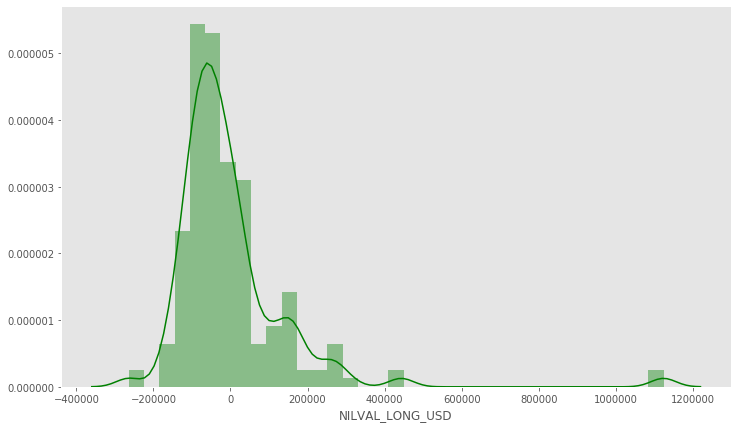

In [359]:
#check how error terms are distributed on train data for Linear Reg RFE
y_res = y_trainbb - y_pred_trainbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

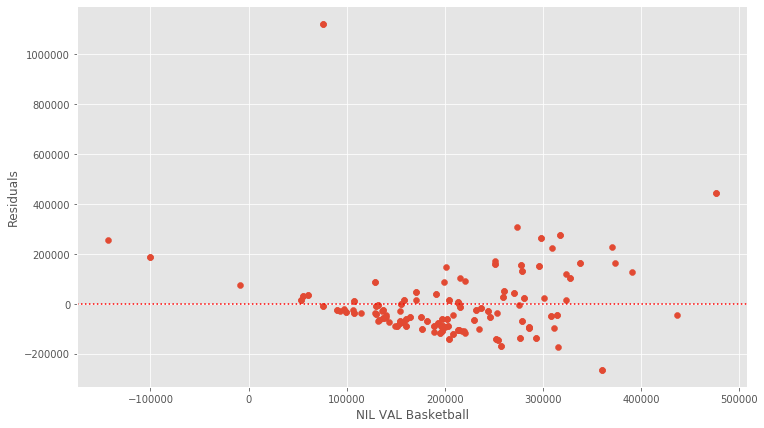

In [360]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_trainbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

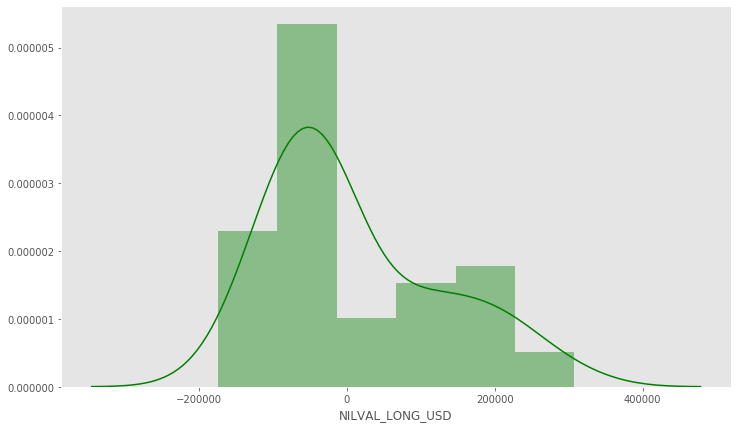

In [361]:
# error terms  distributed on test data
y_res = y_testbb- y_pred_testbb_rfe
plt.figure(figsize=(12,7))
sns.distplot(y_res, kde = True, color = 'g')
plt.grid()
plt.show()

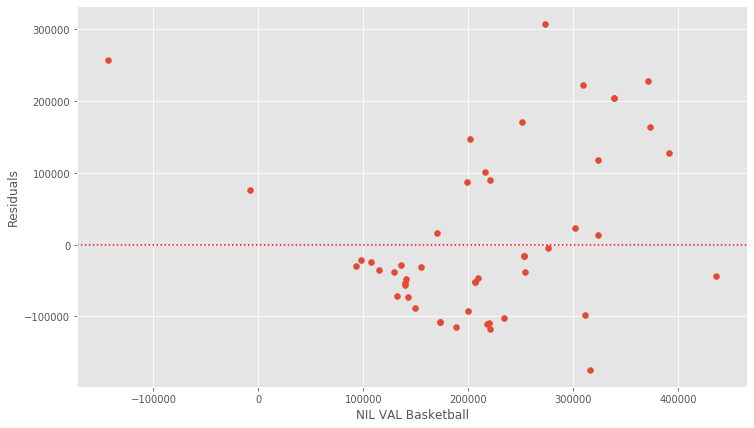

In [362]:
#residual vs predicitons plot
plt.figure(figsize=(12,7))
plt.scatter(y_pred_testbb_rfe, y_res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("NIL VAL Basketball")
plt.ylabel("Residuals")
plt.show()

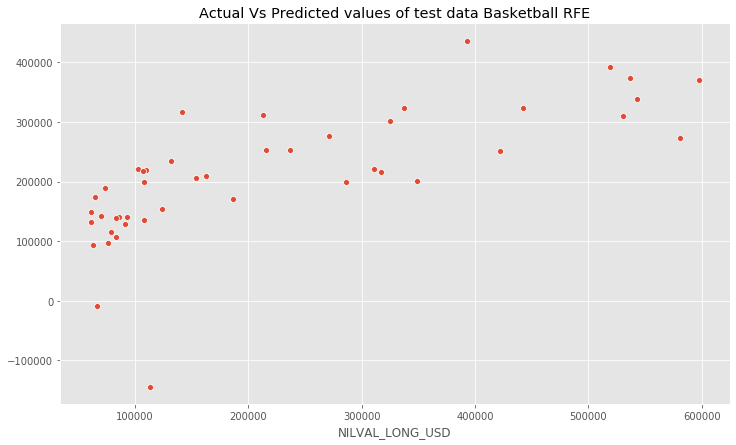

In [363]:
#actual test values vs predicted test values
plt.figure(figsize=(12,7))
plt.title('Actual Vs Predicted values of test data Basketball RFE')
sns.scatterplot(y_testbb,y_pred_testbb_rfe)
plt.show()

**Random Forest Regressor**

In [364]:
# results =pd.DataFrame(results)
# results

In [365]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [366]:
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

In [367]:
#randomized search cv
rcv = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb,y_trainbb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [368]:
# best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 6,
 'max_depth': 5,
 'criterion': 'mae'}

In [369]:
# best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [370]:
#Best score
rcv.best_score_

0.7314745246054214

In [371]:
#Building randomforest regressor with the best estimator 
rf1 = rcv.best_estimator_
#fitting
rf1.fit(X_trainbb,y_trainbb)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [372]:
#feature importances
rf1.feature_importances_
rf1_feature_imp = pd.DataFrame(rf1.feature_importances_, index = X_trainbb.columns, columns = ['Feature_importance'])
rf1_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
rf1_feature_imp

,Feature_importance
SKILL,0.82
AGE,0.09
TWIT_LONG,0.02
NUMOFF,0.02
COLLDIST_MI,0.02
WEIGHT_LBS,0.01
REV_MEN,0.01
EXP_MEN,0.01
INSTA_LONG,0.01
POS,0.00


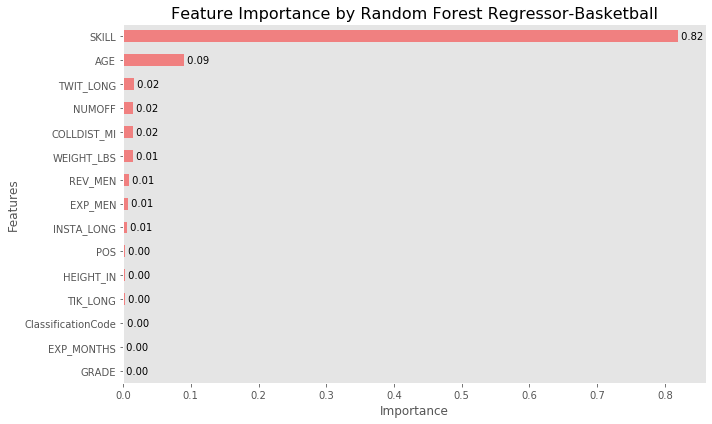

In [373]:
# Feature Visualization

rf1_feature_imp_sorted = rf1_feature_imp.sort_values(by='Feature_importance', ascending=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'lightcoral' for x in rf1_feature_imp_sorted['Feature_importance']]
rf1_feature_imp_sorted['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by Random Forest Regressor-Basketball', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(rf1_feature_imp_sorted.index, fontsize=10)
plt.grid (False)

# Add importance scores at the end of the bars
for i, v in enumerate(rf1_feature_imp_sorted['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )


# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [374]:
from sklearn.feature_selection import SelectFromModel

#Building randomforest regressor with the best estimator 
rf1 = rcv.best_estimator_

#fitting
rf1.fit(X_trainbb,y_trainbb)


# Create an array of threshold values to test
thresholds = [0.01, 0.05, 0.10, 0.20]

# Loop through each threshold value
for threshold in thresholds:
    # Create a SelectFromModel object with the current threshold
    sfm = SelectFromModel(rf1, threshold=threshold)
    
    # Fit SelectFromModel to the training data
    sfm.fit(X_trainbb, y_trainbb)
    
    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Count the number of selected features
    num_selected_features = sum(selected_mask)
    
    print(f"Threshold: {threshold}, Number of Selected Features: {num_selected_features}")

    # Train a new Random Forest model with the selected features
    X_train_selected = sfm.transform(X_trainbb)
    X_test_selected = sfm.transform(X_testbb)
    
    # Create a new Random Forest Regressor with the selected features
    rf_sel = RandomForestRegressor(n_estimators=80, random_state=42)
    
    # Fit the model using the selected features
    rf_sel.fit(X_train_selected, y_trainbb)

    # Get the Boolean mask of selected features
    selected_mask = sfm.get_support()
    
    # Print the threshold and the indices of selected features
    selected_feature_indices = [i for i, is_selected in enumerate(selected_mask) if is_selected]
    print(f"Threshold: {threshold}")
    print(f"Selected Feature Indices: {selected_feature_indices}")
    
    # Make predictions on the test set
    y_pred = rf_sel.predict(X_test_selected)
    
    # Evaluate the model's performance
    rmse = np.sqrt(mean_squared_error(y_testbb, y_pred))
    mae = mean_absolute_error(y_testbb, y_pred)
    r2 = r2_score(y_testbb, y_pred)
    
    print(f"RMSE for Threshold {threshold}: {rmse}")
    print(f"MAE for Threshold {threshold}: {mae}")
    print(f"R-squared (R2) for Threshold {threshold}: {r2}")
  


Threshold: 0.01, Number of Selected Features: 6
Threshold: 0.01
Selected Feature Indices: [1, 2, 3, 6, 7, 9]
RMSE for Threshold 0.01: 32456.789416225132
MAE for Threshold 0.01: 22622.70408163265
R-squared (R2) for Threshold 0.01: 0.962714460451956
Threshold: 0.05, Number of Selected Features: 2
Threshold: 0.05
Selected Feature Indices: [1, 2]
RMSE for Threshold 0.05: 53255.445005491434
MAE for Threshold 0.05: 29458.2155004859
R-squared (R2) for Threshold 0.05: 0.8996176513800415
Threshold: 0.1, Number of Selected Features: 1
Threshold: 0.1
Selected Feature Indices: [2]
RMSE for Threshold 0.1: 68442.6644982005
MAE for Threshold 0.1: 39143.43182186294
R-squared (R2) for Threshold 0.1: 0.8342005317410767
Threshold: 0.2, Number of Selected Features: 1
Threshold: 0.2
Selected Feature Indices: [2]
RMSE for Threshold 0.2: 68442.6644982005
MAE for Threshold 0.2: 39143.43182186294
R-squared (R2) for Threshold 0.2: 0.8342005317410767


In [375]:
# #consider 6 features

feature_names = X_trainbb.columns
sel_feat_indices =  [1, 2, 6, 11, 12, 14]
# Create a list of selected feature names based on selected_feature_indices
selected_feature_names = feature_names[sel_feat_indices]

# Print the names of the selected features
print("Selected Feature Names:")
print(selected_feature_names)

#Considering only the above features
X_trainbb_rf = X_trainbb[selected_feature_names]
X_testbb_rf = X_testbb[selected_feature_names]


Selected Feature Names:
Index(['AGE', 'SKILL', 'WEIGHT_LBS', 'EXP_MONTHS', 'ClassificationCode',
       'EXP_MEN'],
      dtype='object')


In [376]:
#instantiating random forest regressor
rf2 = RandomForestRegressor()

#using Randomized Search CV for hyper parameter tuning
params = {'n_estimators':[5,10,20,40,80,100,200],
          'criterion':['mse','mae'],
          'max_depth':[2,5,10,20],
          'min_samples_split':[2,4,8,12],
          'min_samples_leaf':[2,4,6,8,10],
          'oob_score': [True]}

rcv = RandomizedSearchCV(estimator = rf2, param_distributions = params, n_iter = 10, scoring = 'r2', cv = 10, verbose=5, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb_rf,y_trainbb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [377]:
#best parameters
rcv.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'mae'}

In [378]:
#best estimator
rcv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [379]:
#best score
rcv.best_score_

0.732735998010062

In [380]:
# rebuilding the random forest regressor using the best estimator suggested by the Randomized Search CV
rf2 = rcv.best_estimator_

#fitting on the training data
rf2.fit(X_trainbb_rf,y_trainbb)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [381]:

#predictions on train data
y_pred_train = rf2.predict(X_trainbb_rf)

#predictions on test data
y_pred_test = rf2.predict(X_testbb_rf)

r2_train = r2_score(y_trainbb,y_pred_train)
adj_r2_train = adjusted_r2_score(X_trainbb_rf,y_trainbb,y_pred_train)
# rmse_train = rmse(y_trainbb,y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_trainbb, y_pred_train))

# mae_train = mae(y_trainfb,y_pred_train)
mae_train= mean_absolute_error(y_trainbb, y_pred_train)

r2_test = r2_score(y_testbb,y_pred_test)
adj_r2_test = adjusted_r2_score(X_testbb_rf,y_testbb,y_pred_test)
# rmse_test = rmse(y_testbb,y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_testbb, y_pred_test))
# mae_test = mae(y_testbb,y_pred_test)
mae_test = mean_absolute_error(y_testbb, y_pred_test)

In [382]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ',rmse_test)
print('mae score of test data is ', mae_test)

#Updating the results
new_RFR= ['Random Forest regressor',
                            r2_train,
                            adj_r2_train,
                            rmse_train,
                            mae_train,
                            r2_test,
                            adj_r2_test,
                            rmse_test,
                            mae_test,]
                             

results.loc[len(results)] = new_RFR
results


R2 score of train data is  0.8864026040012034
Adj. R2 score of train data is  0.8827771551927311
rmse score of train data is  61723.37840840726
mae score of train data is  23109.423076923078

R2 score of test data is  0.9396619070132111
Adj. R2 score of train data is  0.9310421794436697
rmse score of test data is  41288.692649305034
mae score of test data is  29042.80612244898


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.24,0.18,159328.64,96056.80,0.52,0.30,116300.96,93021.82
1,Linear Regression_BE,0.18,0.17,165618.14,97060.30,0.55,0.53,113243.54,88300.73
2,Random Forest regressor,0.89,0.88,61723.38,23109.42,0.94,0.93,41288.69,29042.81


**Sensitivity Analysis Random Forest Regressor**

In [383]:
df_bb2.columns

Index(['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
       'COLLDIST_MI', 'NILVAL_LONG_USD', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
       'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'],
      dtype='object')

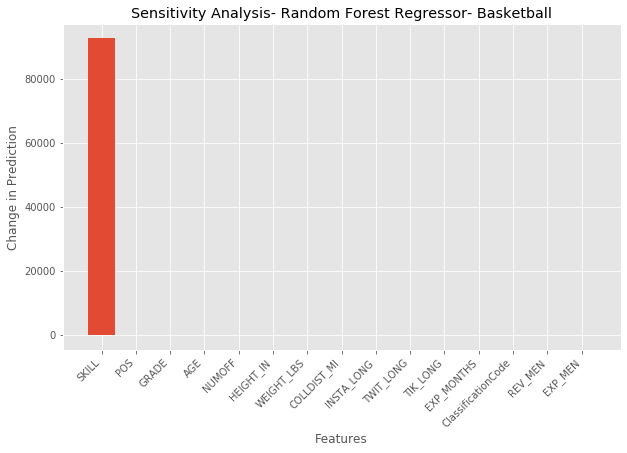

In [384]:
# Train the initial Random Forest model (RF1) using X_trainfb and y_trainfb
rf1.fit(X_trainbb, y_trainbb)

perturbation_value = 0.5 

# Calculate the mean feature values
mean_feature_values = X_trainbb.mean(axis=0)

# Central data point with the mean feature values
central_data_point = mean_feature_values

# Make predictions for the central data point using the initial model (RF1)
predicted_value = rf1.predict([central_data_point])[0]

# List of features to perform sensitivity analysis on
features_to_vary = ['GRADE', 'AGE', 'SKILL', 'NUMOFF', 'POS', 'HEIGHT_IN', 'WEIGHT_LBS',
   'COLLDIST_MI', 'INSTA_LONG', 'TWIT_LONG', 'TIK_LONG',
   'EXP_MONTHS', 'ClassificationCode', 'REV_MEN', 'EXP_MEN'] 

# Convert feature names to column indices
feature_indices = [X_trainbb.columns.get_loc(feature_to_vary) for feature_to_vary in features_to_vary]


# Store the results of sensitivity analysis
sensitivity_results = []

for feature_index in feature_indices:
    feature_name = features_to_vary[feature_index] 

    # Vary the feature value for sensitivity analysis
    perturbed_data_point = np.copy(central_data_point)
    perturbed_data_point[feature_index] += perturbation_value  # Adjust perturbation_value as needed

    # Make predictions for the perturbed data point
    perturbed_value = rf1.predict([perturbed_data_point])[0]

    # Calculate the change in prediction
    prediction_change = perturbed_value - predicted_value

    sensitivity_results.append((feature_name, prediction_change))

# Sort the sensitivity results by the magnitude of change
sensitivity_results.sort(key=lambda x: abs(x[1]), reverse=True)
# print(sensitivity_results)


# Plot the sensitivity results
plt.figure(figsize=(10, 6))
features, changes = zip(*sensitivity_results)
plt.bar(features, changes)
plt.xlabel("Features")
plt.ylabel("Change in Prediction")
plt.xticks(rotation=45, ha="right")  
plt.title("Sensitivity Analysis- Random Forest Regressor- Basketball")
plt.show()





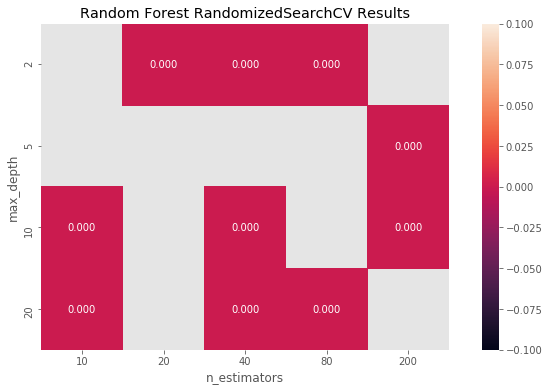

In [385]:
rcv_rf_results = rcv.cv_results_
# print (rcv_rf_results['param_n_estimators'])

param_n_estimators = None
param_max_depth = None
mean_test_score = None
try:
    param_n_estimators = rcv_rf_results['param_n_estimators']
    param_max_depth = rcv_rf_results['param_max_depth']
    mean_test_score = rcv_rf_results['mean_test_score']
except (ValueError, TypeError):
    # Handle data type conversion errors here
    print("Data type conversion error occurred.")

# Create a pivot table for heatmap
data = pd.DataFrame({'n_estimators': param_n_estimators, 'max_depth': param_max_depth, 'Mean R-squared': mean_test_score})

# Check if the 'n_estimators' column contains "?" or other invalid values
data['n_estimators']= data['n_estimators'].astype(int)
data['max_depth'] = data['max_depth'].astype(int)
data['Mean R-squared'] = data['Mean R-squared'].astype(int)


# # Create the pivot table

plt.figure(figsize=(12, 6))
sns.heatmap(data.pivot_table(index='max_depth', columns='n_estimators', values='Mean R-squared'),
            annot=True, fmt=".3f", cbar=True, square=True)
plt.title('Random Forest RandomizedSearchCV Results')
plt.show()



**Random Forest Feature Ablation**

In [396]:
# Initialize variables to store feature importance and performance changes
feature_importance = rf1.feature_importances_
feature_names = X_trainbb.columns  # Replace with your feature names
ablation_mae = []
ablation_r2 = []

rf1.fit(X_trainbb, y_trainbb)
y_pred = rf1.predict(X_testbb)
baseline_mae = mean_absolute_error(y_testbb, y_pred)
baseline_r2 = r2_score(y_testbb, y_pred)

for i in range(X_trainbb.shape[1]):
    # Temporarily remove one feature at a time
    reduced_X_train = X_trainbb.drop(columns= feature_names[i])
    X_test_reduced = X_testbb.drop(columns=feature_names[i])

    # Train a new Random Forest model with one feature removed
    rf1.fit(reduced_X_train, y_trainbb)
    y_pred = rf1.predict(X_test_reduced)
    
    # Calculate MSE and R-squared for the reduced model
    mae = mean_absolute_error(y_testbb, y_pred)
    r2 = r2_score(y_testbb, y_pred)
    
    ablation_mae.append(mae)
    ablation_r2.append(r2)
    
    print(f"Removed {feature_names[i]} - Ablation MAE: {mae}, Ablation R-squared: {r2}")

# # Compare the change in performance metrics with each feature removed
for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    print(f"Removed {feature}: MAE Change: {mae_change}, R-squared Change: {r2_change}")

    # Create a list of dictionaries to store the results
ab_results = []

for i, feature in enumerate(feature_names):
    mae_change = baseline_mae - ablation_mae[i]
    r2_change = ablation_r2[i] - baseline_r2
    result_dict = {
        "Feature Removed": feature,
        "MAE Change": mae_change,
        "R-squared Change": r2_change
    }
    ab_results.append(result_dict)

# Convert the list of dictionaries to a Pandas DataFrame
ablation_df = pd.DataFrame(ab_results)

# Display the DataFrame
display(ablation_df)


Removed GRADE - Ablation MAE: 32567.5, Ablation R-squared: 0.9368617808563987
Removed AGE - Ablation MAE: 40282.5, Ablation R-squared: 0.898935775649873
Removed SKILL - Ablation MAE: 117916.22448979592, Ablation R-squared: 0.07328474691772457
Removed NUMOFF - Ablation MAE: 32025.51020408163, Ablation R-squared: 0.9373736644813578
Removed POS - Ablation MAE: 32899.897959183676, Ablation R-squared: 0.9370184507298426
Removed HEIGHT_IN - Ablation MAE: 32789.744897959186, Ablation R-squared: 0.9334221158801443
Removed WEIGHT_LBS - Ablation MAE: 33356.78571428572, Ablation R-squared: 0.9328336416341317
Removed COLLDIST_MI - Ablation MAE: 31051.88775510204, Ablation R-squared: 0.9378708984325017
Removed INSTA_LONG - Ablation MAE: 31275.408163265307, Ablation R-squared: 0.9400574243830098
Removed TWIT_LONG - Ablation MAE: 32349.948979591838, Ablation R-squared: 0.9369167065872466
Removed TIK_LONG - Ablation MAE: 32241.020408163266, Ablation R-squared: 0.9361202936205733
Removed EXP_MONTHS - A

,Feature Removed,MAE Change,R-squared Change
0,GRADE,-25.26,0.00
1,AGE,-7740.26,-0.04
2,SKILL,-85373.98,-0.86
3,NUMOFF,516.73,0.00
4,POS,-357.65,0.00
5,HEIGHT_IN,-247.50,-0.00
6,WEIGHT_LBS,-814.54,-0.00
7,COLLDIST_MI,1490.36,0.00
8,INSTA_LONG,1266.84,0.00
9,TWIT_LONG,192.30,0.00


**XGBoost**


In [ ]:
xgbr = XGBRegressor()

params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_trainbb,y_trainbb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [ ]:
# best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [ ]:
# best estimator
rcv.best_params_

{'subsample': 1,
 'reg_lambda': 200,
 'reg_alpha': 4,
 'min_child_weight': 8,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

In [ ]:
#best score
rcv.best_score_

0.631384561310341

In [ ]:
#Building XGboost regressor with best hyperparameters
xgbr = rcv.best_estimator_
#Fitting on train data
xgbr.fit(X_trainbb,y_trainbb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [ ]:
#feature importances
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index = X_trainbb.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by = 'Feature_importance', ascending = False, inplace = True)
xgbr_feature_imp

,Feature_importance
SKILL,0.30
ClassificationCode,0.14
WEIGHT_LBS,0.09
EXP_MONTHS,0.09
EXP_MEN,0.07
AGE,0.06
HEIGHT_IN,0.05
INSTA_LONG,0.04
TWIT_LONG,0.03
GRADE,0.03


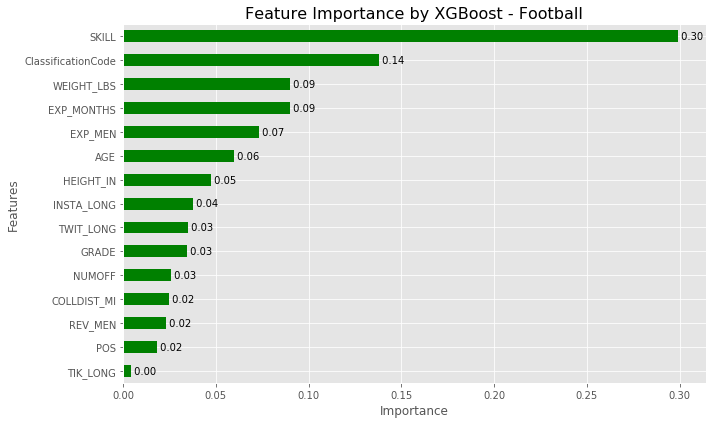

In [ ]:
# Feature Visualization
xgbr_feature_imp = pd.DataFrame(xgbr.feature_importances_, index=X_trainbb.columns, columns=['Feature_importance'])
xgbr_feature_imp.sort_values(by='Feature_importance', ascending=True, inplace=True)


fig, ax = plt.subplots(figsize=(10, 6))
plt.style.use('ggplot')

colors = ['skyblue' if x < 0 else 'green' for x in xgbr_feature_imp['Feature_importance']]
xgbr_feature_imp['Feature_importance'].plot(kind='barh', color=colors, ax=ax)

# Add title and labels
ax.set_title('Feature Importance by XGBoost - Football', fontsize=16)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)

# Add feature names as y-tick labels
ax.set_yticklabels(xgbr_feature_imp.index, fontsize=10)

# Add importance scores at the end of the bars
for i, v in enumerate(xgbr_feature_imp['Feature_importance']):
        plt.text(v, i, f' {v:.2f}', ha='left', va='center', fontsize=10, )

# Adjust the layout for better readability
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#consider top 5 features
xgbr_top_features =  ['GRADE','SKILL',  'INSTA_LONG', 'POS']

In [ ]:
X_train_xgbr = X_trainbb[xgbr_top_features]
X_test_xgbr = X_testbb[xgbr_top_features]

In [ ]:
#Fitting on the training data
xgbr2 = XGBRegressor()
params = {
          'learning_rate': [0.1,0.2,0.5,0.8,1],
          'max_depth': [2,3,4,5,6,7,8,10],
          'subsample': [0.001,0.009,0.01,0.09,0.1,0.4,0.9,1],
          'min_child_weight': [1,2,4,5,8],
          'gamma': [0.0,0.1,0.2,0.3],
          'colsample_bytree': [0.3,0.5,0.7,1.0,1.4],
          'reg_alpha': [0,0.1,0.2,0.4,0.5,0.7,0.9,1,4,8,10,50,100],
          'reg_lambda': [1,4,5,10,20,50,100,200,500,800,1000]
          
         }

#Using Randomized search cv
rcv = RandomizedSearchCV(estimator=xgbr2, param_distributions=params, n_iter = 10, 
                                scoring='r2', cv = 10, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)
rcv.fit(X_train_xgbr,y_trainbb)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=No...
                                        'learning_rate': [0.1, 0.2, 0.5, 0.8,
                                                          1],
         

In [ ]:
#best estimator
rcv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [ ]:
#best params
rcv.best_params_

{'subsample': 1,
 'reg_lambda': 200,
 'reg_alpha': 4,
 'min_child_weight': 8,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

In [ ]:
#best score
rcv.best_score_

0.5332268565024956

In [ ]:
xgbr2 = rcv.best_estimator_
#fitting
xgbr2.fit(X_train_xgbr, y_trainbb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=4, ...)

In [ ]:
#Predictions on train data
y_pred_train = xgbr2.predict(X_train_xgbr)

#predictions on test data
y_pred_test = xgbr2.predict(X_test_xgbr)


r2_train= r2_score(y_trainbb ,y_pred_train)
adj_r2_train = adjusted_r2_score(X_train_xgbr,y_trainbb ,y_pred_train)
rmse_train = rmse(y_trainbb ,y_pred_train)
mae_train = (y_trainbb ,y_pred_train)

r2_test = r2_score(y_testbb ,y_pred_test)
adj_r2_test = adjusted_r2_score(X_test_xgbr,y_testbb,y_pred_test)
rmse_train = rmse(y_testbb,y_pred_test)
mae_train = mae(y_testbb,y_pred_test)


In [ ]:
print('R2 score of train data is ',r2_train)
print('Adj. R2 score of train data is ',adj_r2_train)
print('rmse score of train data is ',rmse_train)
print('mae score of train data is ',mae_train)
print()
print('R2 score of test data is ',r2_test)
print('Adj. R2 score of train data is ',adj_r2_test)
print('rmse score of test data is ', rmse_test)
print('maescore of test data is ',mae_test)

#storing in results
new_xgb= ['XG Boost regressor',
          r2_train,
          adj_r2_train,
          rmse_train,
          mae_train,
          r2_test,
          adj_r2_test,
          rmse_test,
          mae_test,
                             
                             ]

results.loc[len(results)] = new_xgb
results

R2 score of train data is  0.5943455875017958
Adj. R2 score of train data is  0.5813991700816403
rmse score of train data is  116638.95046032942
mae score of train data is  34516.61538461538

R2 score of test data is  0.9378139387896983
Adj. R2 score of train data is  0.9289302157596552
rmse score of test data is  41916.196415452294
maescore of test data is  31375.30612244898


,Algorithm,Train_R2 score,Train_Adj_R2 score,Train_RMSE score,Train_MAE score,Test_R2 score,Test_Adj_R2 score,Test_RMSE score,Test_MAE score
0,Linear Regression_RFE,0.24,0.18,159328.64,96056.80,0.52,0.30,116300.96,93021.82
1,Linear Regression_BE,0.18,0.17,165618.14,97060.30,0.55,0.53,113243.54,88300.73
2,Random Forest regressor,0.59,0.58,116638.95,34516.62,0.94,0.93,41916.20,31375.31
3,XG Boost regressor,0.59,0.58,116638.95,34516.62,0.94,0.93,41916.20,31375.31


In [412]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import pandas as pd

# Define your XGBoost Regressor model
xgbr2 = rcv.best_estimator_

# Assuming X_train_xgbr and y_trainbb are your training data
# Set the number of folds (k) for cross-validation, e.g., 5-fold
k = 5

# Define custom scoring functions for MAE and RMSE
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

# Perform k-fold cross-validation with custom scoring functions
cv_results = cross_validate(xgbr2, X_train_xgbr, y_trainbb, cv=k, scoring=scoring)

# Calculate mean scores
mean_r2_cv = np.mean(cv_results['test_r2'])
mean_mae_cv = np.mean(-cv_results['test_neg_mean_absolute_error'])
mean_rmse_score = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))

# Create a dictionary with the results
cv_scores_dict = {
    "Model": 'XGBoost',
    "Mean R2 CV Score": mean_r2_cv,
    "Mean MAE CV Score": mean_mae_cv,
    "Mean RMSE CV Score": mean_rmse_score
}

# Convert the dictionary to a Pandas DataFrame
cv_scores_df = pd.DataFrame([cv_scores_dict])

# Display the DataFrame
display(cv_scores_df)


,Model,Mean R2 CV Score,Mean MAE CV Score,Mean RMSE CV Score
0,XGBoost,0.54,58435.79,116018.66
